# Image Classification Example

In [2]:
import sys

sys.path.insert(0, "image_classifier")

In [3]:
import matplotlib.pyplot as plt
import torch
from hydra_zen import instantiate, to_yaml
from image_classifier import configs

## Dataset

In [4]:
print(to_yaml(configs.CIFAR10ModuleConf(batch_size=10)))

_target_: pytorch_lightning.core.datamodule.LightningDataModule.from_datasets
_recursive_: true
_convert_: none
num_workers: 4
batch_size: 10
train_dataset:
  _target_: torchvision.datasets.cifar.CIFAR10
  _recursive_: true
  _convert_: none
  root: ${env:HOME}/.raiden
  train: true
  transform:
    _target_: torchvision.transforms.transforms.Compose
    _recursive_: true
    _convert_: none
    transforms:
    - _target_: torchvision.transforms.transforms.RandomCrop
      _recursive_: true
      _convert_: none
      size: 32
      padding: 4
    - _target_: torchvision.transforms.transforms.RandomHorizontalFlip
      _recursive_: true
      _convert_: none
    - _target_: torchvision.transforms.transforms.ColorJitter
      _recursive_: true
      _convert_: none
      brightness: 0.25
      contrast: 0.25
      saturation: 0.25
    - _target_: torchvision.transforms.transforms.RandomRotation
      _recursive_: true
      _convert_: none
      degrees: 2
    - _target_: torchvision.tr

In [5]:
data = instantiate(configs.CIFAR10ModuleConf(batch_size=10))

/home/justin_goodwin/.conda/envs/raiden-release/lib/python3.8/site-packages/omegaconf/omegaconf.py:99: UserWarning: The `env` resolver is deprecated, see https://github.com/omry/omegaconf/issues/573
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [6]:
x, y = next(iter(data.test_dataloader()))
x.shape

torch.Size([10, 3, 32, 32])

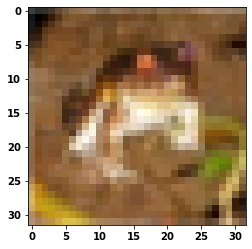

In [7]:
plt.imshow(x[0].permute(1, 2, 0).numpy())

## Model

In [8]:
module = instantiate(
    configs.ImageClassificationConf(model=configs.ResNet50Conf, optim=configs.SGDConf)
)

### Test with pre-trained model

In [9]:
# Download a version from here
from pathlib import Path

Path("data").mkdir(exist_ok=True)
ckpt = Path("data") / "torchvision_cifar_l2_1_0.pt"
if not ckpt.exists():
    import requests

    headers = {"user-agent": "Wget/1.16 (linux-gnu)"}
    url = "https://www.dropbox.com/s/oagh1e6vji2z252/torchvision_cifar_l2_1_0.pt?dl=1"
    r = requests.get(url, stream=True, headers=headers)
    with open(ckpt, "wb") as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)

module.model.load_state_dict(torch.load(ckpt)['state_dict'])

<All keys matched successfully>

In [10]:
module.eval()
module(x).argmax(1) == y

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True])

## Train

In [34]:
# trainer = instantiate(configs.TrainerConf(accelerator="dp", default_root_dir="outputs/lightning", max_epochs=1))
# trainer.fit(module, datamodule=data)

## Hydra-Run

In [12]:
from hydra_zen.experimental import hydra_run

In [13]:
def task_function(cfg):
    data = instantiate(cfg.experiment.lightning_data_module)
    model = instantiate(cfg.experiment.lightning_model)
    trainer = instantiate(cfg.experiment.lightning_trainer)
    trainer.fit(model, datamodule=data)
    return model

In [28]:
Config = dict(
    experiment = dict(
        lightning_data_module=configs.CIFAR10ModuleConf,
        lightning_model=configs.ImageClassificationConf(model="${model}", optim="${optim}"),
        lightning_trainer=configs.TrainerConf  # Note since we are running Hydra we can use the default accelerator DDP in the notebook
    ),
    model=None,
    optim=None,
)

In [29]:
job = hydra_run(
    Config,
    task_function=task_function,
    overrides=["+model=resnet18", "+optim=sgd", "optim.lr=0.05", "experiment.lightning_data_module.batch_size=512", "experiment.lightning_trainer.max_epochs=1"]
)

/home/justin_goodwin/.conda/envs/raiden-release/lib/python3.8/site-packages/omegaconf/omegaconf.py:99: UserWarning: The `env` resolver is deprecated, see https://github.com/omry/omegaconf/issues/573
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type             | Params
------------------------------------------------
0 | model      | ResNet           | 11.2 M
1 | predictor  | Softmax          | 0     
2 | normalizer | Normalize        | 0     
3 | criterion  | CrossEntropyLoss | 0     
4 | metrics    | MetricCollection | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [30]:
job.working_dir

'outputs/2021-04-27/10-40-25'

In [31]:
trained_module = job.return_value

## Hydra-Multirun

In [32]:
from hydra_zen.experimental import hydra_multirun

In [33]:
job = hydra_multirun(
    Config,
    task_function=task_function,
    overrides=["+model=resnet18,resnet50", "+optim=sgd,adam", "experiment.lightning_data_module.batch_size=256,512", "experiment.lightning_trainer.max_epochs=1"]
)

[2021-04-27 10:41:42,761][HYDRA] Launching 8 jobs locally
[2021-04-27 10:41:42,761][HYDRA] 	#0 : experiment.lightning_data_module.batch_size=256 experiment.lightning_trainer.max_epochs=1 +optim=sgd +model=resnet18


/home/justin_goodwin/.conda/envs/raiden-release/lib/python3.8/site-packages/omegaconf/omegaconf.py:99: UserWarning: The `env` resolver is deprecated, see https://github.com/omry/omegaconf/issues/573
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type             | Params
------------------------------------------------
0 | model      | ResNet           | 11.2 M
1 | predictor  | Softmax          | 0     
2 | normalizer | Normalize        | 0     
3 | criterion  | CrossEntropyLoss | 0     
4 | metrics    | MetricCollection | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[2021-04-27 10:42:09,588][HYDRA] 	#1 : experiment.lightning_data_module.batch_size=256 experiment.lightning_trainer.max_epochs=1 +optim=sgd +model=resnet50
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type             | Params
------------------------------------------------
0 | model      | ResNet           | 23.5 M
1 | predictor  | Softmax          | 0     
2 | normalizer | Normalize        | 0     
3 | criterion  | CrossEntropyLoss | 0     
4 | metrics    | MetricCollection | 0     
------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.083    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[2021-04-27 10:43:25,404][HYDRA] 	#2 : experiment.lightning_data_module.batch_size=256 experiment.lightning_trainer.max_epochs=1 +optim=adam +model=resnet18
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type             | Params
------------------------------------------------
0 | model      | ResNet           | 11.2 M
1 | predictor  | Softmax          | 0     
2 | normalizer | Normalize        | 0     
3 | criterion  | CrossEntropyLoss | 0     
4 | metrics    | MetricCollection | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[2021-04-27 10:43:54,249][HYDRA] 	#3 : experiment.lightning_data_module.batch_size=256 experiment.lightning_trainer.max_epochs=1 +optim=adam +model=resnet50
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type             | Params
------------------------------------------------
0 | model      | ResNet           | 23.5 M
1 | predictor  | Softmax          | 0     
2 | normalizer | Normalize        | 0     
3 | criterion  | CrossEntropyLoss | 0     
4 | metrics    | MetricCollection | 0     
------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.083    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[2021-04-27 10:45:12,234][HYDRA] 	#4 : experiment.lightning_data_module.batch_size=512 experiment.lightning_trainer.max_epochs=1 +optim=sgd +model=resnet18
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type             | Params
------------------------------------------------
0 | model      | ResNet           | 11.2 M
1 | predictor  | Softmax          | 0     
2 | normalizer | Normalize        | 0     
3 | criterion  | CrossEntropyLoss | 0     
4 | metrics    | MetricCollection | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[2021-04-27 10:45:39,043][HYDRA] 	#5 : experiment.lightning_data_module.batch_size=512 experiment.lightning_trainer.max_epochs=1 +optim=sgd +model=resnet50
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type             | Params
------------------------------------------------
0 | model      | ResNet           | 23.5 M
1 | predictor  | Softmax          | 0     
2 | normalizer | Normalize        | 0     
3 | criterion  | CrossEntropyLoss | 0     
4 | metrics    | MetricCollection | 0     
------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.083    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[2021-04-27 10:46:53,489][HYDRA] 	#6 : experiment.lightning_data_module.batch_size=512 experiment.lightning_trainer.max_epochs=1 +optim=adam +model=resnet18
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type             | Params
------------------------------------------------
0 | model      | ResNet           | 11.2 M
1 | predictor  | Softmax          | 0     
2 | normalizer | Normalize        | 0     
3 | criterion  | CrossEntropyLoss | 0     
4 | metrics    | MetricCollection | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[2021-04-27 10:47:21,468][HYDRA] 	#7 : experiment.lightning_data_module.batch_size=512 experiment.lightning_trainer.max_epochs=1 +optim=adam +model=resnet50
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type             | Params
------------------------------------------------
0 | model      | ResNet           | 23.5 M
1 | predictor  | Softmax          | 0     
2 | normalizer | Normalize        | 0     
3 | criterion  | CrossEntropyLoss | 0     
4 | metrics    | MetricCollection | 0     
------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.083    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]